<img src="../thumbnail.svg" width=250 alt="Intake Logo"></img>

# Introduction to Intake

---

## Overview
[Intake](https://intake.readthedocs.io/en/latest/) is a python library that provides a consistent interface for accessing data regardless of where or how it is stored. In this notebook you will learn to:

1. Interact with Intake catalogs
1. Use Intake to access data stored in the cloud
1. Use Intake to load data into Dask

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Times and Dates in Python](https://foundations.projectpythia.org/core/datetime/datetime.html) | Necessary | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Intro to Cartopy](../core/cartopy/cartopy) | Helpful | |
| [Understanding of Zarr](https://zarr.readthedocs.io/en/stable/) | Helpful | |
| [Understanding of Dask](https://www.dask.org/) | Helpful | |


- **Time to learn**: 45 minutes

---

## Imports

In [18]:
import intake
import xarray as xr
import datetime as dt
import metpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import requests
import aiohttp
import intake_xarray

## Interacting with Intake Catalogs

Intake uses an object called a catalog to inform users what datasets are available to them. These catalogs can be in the form of a yaml file, a server, or a python package you install. In this example we will use a catalog to access [Mesowest's HRRR data](https://mesowest.utah.edu/html/hrrr/) stored on AWS S3. To open a catalog use the `open_catalog` function with the location of the catalog as an argument. The catalog object created by calling `open_catalog` is iterable, so you can see what data sources are available to you by passing your catalog object as an argument to python's `list` function.

In [19]:
cat = intake.open_catalog('catalog.yml')
list(cat)

['data_dictionary', 'hrrrzarr', 'readme']

Each of the catalog's sources are accessible as properties of your catalog object.

In [3]:
cat.hrrrzarr

hrrrzarr:
  args:
    chunks:
      projection_x_coordinate: 1799
      projection_y_coordinate: 1059
    storage_options:
      anon: true
    urlpath:
    - s3://hrrrzarr/sfc/20160824/20160824_00z_anl.zarr/surface/TMP
    - s3://hrrrzarr/sfc/20160824/20160824_00z_anl.zarr/surface/TMP/surface
  description: An Intake catalog containing Mesowest HRRR data. See readme source
    for more information.
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /Users/jmorley/Documents/intake-cookbook/notebooks/
    coords: !!python/tuple
    - projection_x_coordinate
    - projection_y_coordinate
    dims:
      projection_x_coordinate: 1799
      projection_y_coordinate: 1059


### Learning About Catalog Entries

The first place you can look for information about a catalog source is it's description. That is stored in the data sources's `description` property.

In [4]:
cat.hrrrzarr.description

'An Intake catalog containing Mesowest HRRR data. See readme source for more information.'

To get a better look at a source in a Intake catalog, call it's `describe` function

In [5]:
desc = cat.hrrrzarr.describe()
desc

{'name': 'hrrrzarr',
 'container': 'xarray',
 'plugin': ['zarr'],
 'driver': ['zarr'],
 'description': 'An Intake catalog containing Mesowest HRRR data. See readme source for more information.',
 'direct_access': 'forbid',
 'user_parameters': [{'name': 'date',
   'description': 'The date and hour you want data for.',
   'type': 'datetime',
   'min': Timestamp('2016-08-24 00:00:00'),
   'default': Timestamp('2016-08-24 00:00:00')},
  {'name': 'level',
   'description': 'Parameter specifying what level in the atmosphere your dataset will describe.',
   'type': 'str',
   'default': 'surface'},
  {'name': 'param',
   'description': 'Specifies what parameter your dataset will contain.',
   'type': 'str',
   'default': 'TMP'}],
 'metadata': {'coords': ('projection_x_coordinate', 'projection_y_coordinate'),
  'dims': {'projection_x_coordinate': 1799, 'projection_y_coordinate': 1059}},
 'args': {'chunks': {'projection_x_coordinate': 1799,
   'projection_y_coordinate': 1059},
  'storage_options

From this Python dictionary there are a few things that we can learn. The `container` key tells us what form the data will be in when we read it. In this case it will be a [Xarray](https://foundations.projectpythia.org/core/xarray.html) `Dataset` The `user_parameters` key has a list containing parameters a user can set to control what data they get. The `metadata` key contains an arbitrary dictionary of information specified by the catalog author. A common things to find in the `metadata` field are plots you can use to get a quick peak at the data.

## Reading Data with intake
Now that we know how to explore intake catalogs, lets use one to get some data. Luckily Intake makes this a really easy one-liner.

In [6]:
ds = cat.hrrrzarr.read()
ds

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 ...
    forecast_period          timedelta64[ns] 00:00:00
    forecast_reference_time  datetime64[ns] 2016-08-24
    height                   float64 1e+03
    pressure                 float64 2.5e+04
    time                     datetime64[ns] 2016-08-24

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Intake catalogs access data lazily. You can explore that catalog all you want, but you won't have any data until use call the <code>read</code> or simillar function. The <code>read</code> function may take longer to run depending on your internet connection, the size of the data, and your proximity to the data center where the data is stored.
</div>

### Specifying User Parameters

The hrrrzarr sources in this catalog has three parameters that can be used to control what data you will read in. To list those use the `user_parameters` key on the description dictionary created above.

In [7]:
desc['user_parameters']

[{'name': 'date',
  'description': 'The date and hour you want data for.',
  'type': 'datetime',
  'min': Timestamp('2016-08-24 00:00:00'),
  'default': Timestamp('2016-08-24 00:00:00')},
 {'name': 'level',
  'description': 'Parameter specifying what level in the atmosphere your dataset will describe.',
  'type': 'str',
  'default': 'surface'},
 {'name': 'param',
  'description': 'Specifies what parameter your dataset will contain.',
  'type': 'str',
  'default': 'TMP'}]

Each user parameter can have a name, description, type, defualt, allowed, min, and max attribute. You can learn more about [parameter definitions](https://intake.readthedocs.io/en/latest/catalog.html#parameter-definition) in Intake's documentation. This data source contains three user parameters: `date`, `level`, and `param`. Each parameter's descriptions explain what they are for. The `level` and `param` parameter allow you to select data based on level in the atmosphere and variable being measured. There allowed values correspond to values in the "Vertical Level" and "Parameter Short Name" column in the data_dictionary source repectively. The `date` parameter allows you to select data by date.

In [33]:
data_dictionary = cat.data_dictionary.read()
data_dictionary.query("`Vertical Level` == 'surface'")[:10]

,Parameter Long Name,Vertical Level,Parameter Short Name,Units,1st Version Available,Analysis or Forcast,Notes
133,Visibility,surface,VIS,m,V3,both,
134,Wind Gust,surface,GUST,m/s,V3,both,
135,Hail,surface,HAIL_max_fcst,m,V4,anl,
136,Hail,surface,HAIL_1hr_max_fcst,m,V4,fcst,
137,Pressure,surface,PRES,Pa,V3,both,
138,Geopotential Height,surface,HGT,gpm,V3,both,
139,Temperature,surface,TMP,K,V3,both,
140,Total Snowfall,surface,ASNOW_acc_fcst,m,V3,both,
141,Total Snowfall,surface,ASNOW_1hr_acc_fcst,m,V3,fcst,
142,Plant Canopy Surface Water,surface,CNWAT,kg/m2,V3,both,


Lets use parameters to select surface temperature data from June 20, 2021. We can provide these parameter by passing keyword arguments to the data source. 

In [34]:
summer_solstice_2021 = dt.datetime(2021, 6, 20)
source = cat.hrrrzarr(date=summer_solstice_2021, level='surface', param='TMP')
source.read()

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 ...
    forecast_period          timedelta64[ns] 00:00:00
    forecast_reference_time  datetime64[ns] 2021-06-20
    height                   float64 1e+03
    pressure                 float64 2.5e+04
    time                     datetime64[ns] 2021-06-20

Your data source now points to surface temperature data taken June 20, 2021 

### A more complicated example

Mesowest provides a [tutorial](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/xarray_one_day_analysis_example.html) for reading a days worth of surface temperature HRRR data from AWS. Lets see what the same task looks like using Intake.

We will start by setting up our [Cartopy](https://foundations.projectpythia.org/core/cartopy.html) Projection

In [10]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

Now lets read in the data with Intake. To do this will create a [datetime](https://foundations.projectpythia.org/core/datetime.html) object with the date August 9, 2019. Then we will use list comprehension and timedeltas to create a [datetime](https://foundations.projectpythia.org/core/datetime.html) object for each hour that day. Again using, list comprehension, we will create a list of datasets using Intake.

In [11]:
date = dt.datetime(2019, 8, 9)
dates = [date + dt.timedelta(hours=i) for i in range(24)]
datasets = [cat.hrrrzarr(date=hour).read() for hour in dates]
datasets[0]

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 ...
    forecast_period          timedelta64[ns] 00:00:00
    forecast_reference_time  datetime64[ns] 2019-08-09
    height                   float64 1e+03
    pressure                 float64 2.5e+04
    time                     datetime64[ns] 2019-08-09

Unfortunately, the data is not quite ready to use after reading it in with intake. To get it into a more useful state, we will define a function that will rename the coordinates to `x` and `y`, create latitude and longitude coordinates from the `x` and `y` coordinates, and then change the `time` variable into a coordinate. This will allow you to concatenate multiple datasets together along the time dimension.

In [35]:
def prepare_dataset(ds):
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds

We will use list comprehension to map our function across each dataset in our list and then use [Xarray](https://foundations.projectpythia.org/core/xarray.html) to concatenate the datasets.

In [13]:
datasets = [prepare_dataset(dataset) for dataset in datasets]
ds = xr.concat(datasets, dim='time', combine_attrs="drop_conflicts")

Now our data is ready to be analyzed in the normal way using [Xarray](https://foundations.projectpythia.org/core/xarray.html).

In [14]:
avg_TMP = ds.TMP.mean(dim='time')
avg_TMP.values

array([[297.5, 297.5, 297.5, ..., 302. , 302. , 302. ],
       [297.5, 297.5, 297.5, ..., 302. , 302. , 302. ],
       [297.5, 297.8, 297.8, ..., 302. , 302. , 302. ],
       ...,
       [289.2, 289.2, 289.2, ..., 292.2, 292.2, 292. ],
       [289.2, 289.2, 289.2, ..., 292.2, 292. , 292. ],
       [289.2, 289.2, 289.2, ..., 292. , 292. , 292. ]], dtype=float16)

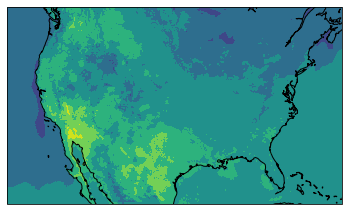

In [15]:
ax = plt.axes(projection=projection)
ax.contourf(avg_TMP.x, avg_TMP.y, avg_TMP)
ax.coastlines()

plt.show()

### Using Intake with Dask
Often times the data we want to analyze is too big to be loaded into memory all at once on your computer. [Dask]() solves this problem by breaking up your data into smaller chunks, operating on each chunck of data, and then aggregating the results. This is usually done in parallel on a cluster system. You can use Intake to create a Dask dataset by using the `to_dask` method instead of the `read` method.

In [17]:
ds1 = cat.hrrrzarr(date=dt.datetime(2021, 1, 1)).read()
print(type(ds1.TMP.data))

ds2 = cat.hrrrzarr(date=dt.datetime(2022, 1, 1)).to_dask()
print(type(ds2.TMP.data))

<class 'numpy.ndarray'>
<class 'dask.array.core.Array'>


As you can see [Xarray](https://foundations.projectpythia.org/core/xarray.html) uses Dask arrays instead of [NumPy](https://foundations.projectpythia.org/core/numpy.html) arrays to hold the data when the `to_dask` function is used.

---

## Summary
- Intake makes it easy to consistently access data regardless of where and how it is stored
- Intake catalogs contain useful information about the data they make available
- Intake can load data into Dask for use in parallel computing. 

### What's next?
In the next notebook we will look at writing a Intake catalog and making it available on [Github](https://foundations.projectpythia.org/foundations/getting-started-github.html).

## Resources and references

- [HRRR Zarr Example Using XArray (Mesowest)](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/xarray_one_day_analysis_example.html)
- [Intake Documentation](https://intake.readthedocs.io/en/latest/index.html)
- [NOAA High-Resolution Rapid Refresh (HRRR) Data Archive](https://mesowest.utah.edu/html/hrrr/)